In [21]:
# Import các thư viện cần thiết
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import datetime, os
import os, datetime, pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Kiểm tra GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    print("Training will use GPU")
else:
    print("Training will use CPU")

GPU Available: []
Training will use CPU


In [40]:
# 1) TensorBoard callback
base_dir = pathlib.Path(r"C:\Users\LENOVO\Desktop\DeepLearning")  # <-- CHỈNH CHO PHÙ HỢP (nếu cần)
log_dir = base_dir / "logs" / "fit" / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir.parent.mkdir(parents=True, exist_ok=True)
tensorboard_cb = TensorBoard(log_dir=str(log_dir), histogram_freq=1, write_graph=True)

In [41]:
# 5) Các callback hữu ích ngoài TensorBoard
ckpt_path = base_dir / "bigkernel_cnn_cifar100.h5"
callbacks = [
    tensorboard_cb,
    ModelCheckpoint(str(ckpt_path), monitor="val_loss", mode="min", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", mode="min", patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]


In [11]:
# Hàm load dữ liệu CIFAR-100
def load_cifar100_batch(file):
    with open(file, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch

# Load training data
train_path = r'C:\Users\LENOVO\Desktop\DeepLearning\cifar-100-python\train'
train_data = load_cifar100_batch(train_path)

# Load test data
test_path = r'C:\Users\LENOVO\Desktop\DeepLearning\cifar-100-python\test'
test_data = load_cifar100_batch(test_path)

# Trích xuất dữ liệu
X_train = train_data[b'data']
y_train = np.array(train_data[b'fine_labels'])

X_test = test_data[b'data']
y_test = np.array(test_data[b'fine_labels'])

# Reshape dữ liệu về dạng ảnh (32x32x3)
X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Chuẩn hóa dữ liệu về [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encoding cho labels (100 classes)
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

# Tạo validation set từ training set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: 100")

Training set shape: (45000, 32, 32, 3)
Validation set shape: (5000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
Number of classes: 100


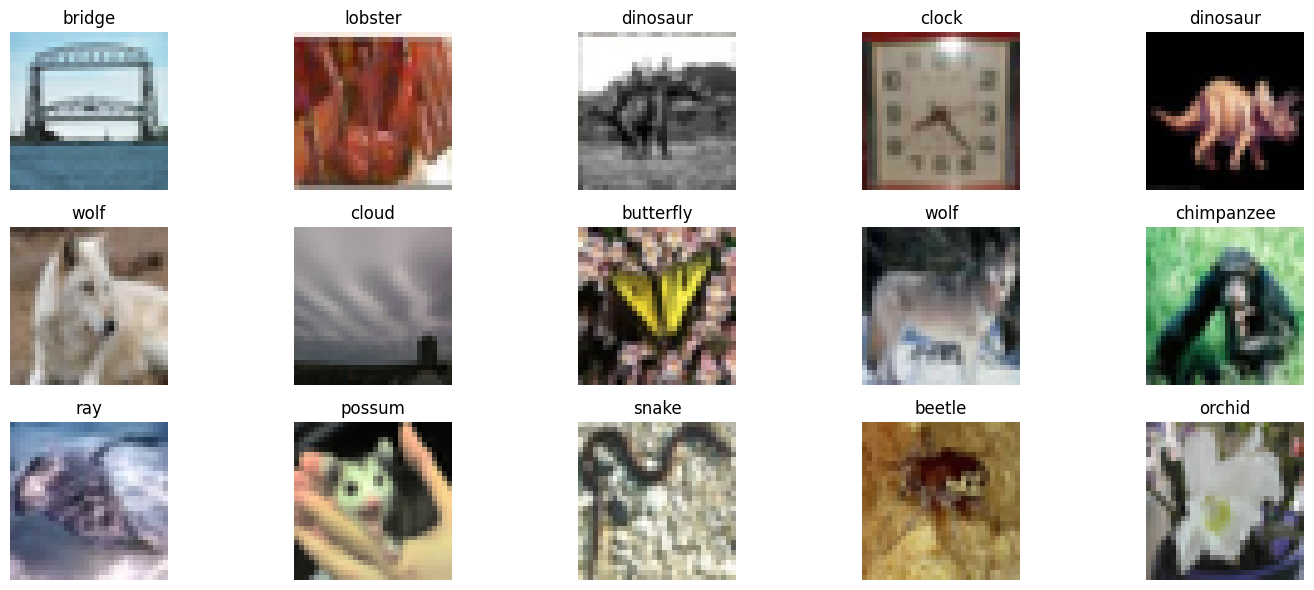

In [17]:
# Load meta data để lấy tên các lớp
meta_path = r'C:\Users\LENOVO\Desktop\DeepLearning\cifar-100-python\meta'
meta_data = load_cifar100_batch(meta_path)
class_names = [name.decode('utf-8') for name in meta_data[b'fine_label_names']]

# Hiển thị một số ảnh mẫu
plt.figure(figsize=(15, 6))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_names[np.argmax(y_train[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Xây dựng mô hình BigKernel CNN
# Lớp Conv2D đầu tiên sử dụng kernel 9x9 (yêu cầu kernel lớn)

model = Sequential([
    # Block 1: Big Kernel Layer (9x9)
    Conv2D(64, kernel_size=(9, 9), strides=1, padding='same', 
           activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    # Block 2: Standard Conv Layer
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    # Block 3: Deeper Conv Layers
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # Block 4: Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output Layer (100 classes cho CIFAR-100)
    Dense(100, activation='softmax')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Hiển thị kiến trúc model
model.summary()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,02

 Total params: 3,383,396 (12.91 MB)

 Trainable params: 3,380,196 (12.89 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [7]:
# Định nghĩa callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Training model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 138s 98ms/step - accuracy: 0.0977 - loss: 3.9843 - val_accuracy: 0.1354 - val_loss: 3.6759 - learning_rate: 0.0010
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 140s 100ms/step - accuracy: 0.1677 - loss: 3.4836 - val_accuracy: 0.2190 - val_loss: 3.1994 - learning_rate: 0.0010
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 141s 100ms/step - accuracy: 0.2210 - loss: 3.1952 - val_accuracy: 0.2960 - val_loss: 2.8175 - learning_rate: 0.0010
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 156s 111ms/step - accuracy: 0.2644 - loss: 2.9411 - val_accuracy: 0.3442 - val_loss: 2.5501 - learning_rate: 0.0010
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 166s 118ms/step - accuracy: 0.3036 - loss: 2.7389 - val_accuracy: 0.3534 - val_loss: 2.5202 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [8]:
# Định nghĩa callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Training model
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 129s 184ms/step - accuracy: 0.3628 - loss: 2.4478 - val_accuracy: 0.4122 - val_loss: 2.2227 - learning_rate: 0.0010
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 128s 182ms/step - accuracy: 0.3883 - loss: 2.3264 - val_accuracy: 0.4316 - val_loss: 2.1718 - learning_rate: 0.0010
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 222s 315ms/step - accuracy: 0.4113 - loss: 2.2279 - val_accuracy: 0.4316 - val_loss: 2.1280 - learning_rate: 0.0010
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 163s 232ms/step - accuracy: 0.4266 - loss: 2.1407 - val_accuracy: 0.4394 - val_loss: 2.1342 - learning_rate: 0.0010
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 149s 211ms/step - accuracy: 0.4459 - loss: 2.0509 - val_accuracy: 0.4474 - val_loss: 2.0831 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [9]:
# Định nghĩa callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Training model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 153s 109ms/step - accuracy: 0.4134 - loss: 2.2040 - val_accuracy: 0.4470 - val_loss: 2.0675 - learning_rate: 0.0010
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 178s 127ms/step - accuracy: 0.4372 - loss: 2.0911 - val_accuracy: 0.4678 - val_loss: 2.0039 - learning_rate: 0.0010
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 342s 243ms/step - accuracy: 0.4601 - loss: 2.0048 - val_accuracy: 0.4674 - val_loss: 1.9953 - learning_rate: 0.0010
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 317s 225ms/step - accuracy: 0.4728 - loss: 1.9385 - val_accuracy: 0.4728 - val_loss: 1.9775 - learning_rate: 0.0010
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 325s 231ms/step - accuracy: 0.4816 - loss: 1.8847 - val_accuracy: 0.4634 - val_loss: 2.0316 - learning_rate: 0.0010
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 308s 219ms/step - accuracy: 0.5009 - loss: 1.8155 - val_accuracy: 0.4736 - val_loss: 2.0286 - learning_rate: 0.0010
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 146s 104ms

In [10]:
# Định nghĩa callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Training model
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 202ms/step - accuracy: 0.6789 - loss: 1.0818 - val_accuracy: 0.5382 - val_loss: 1.8145 - learning_rate: 1.2500e-04
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 197s 281ms/step - accuracy: 0.6895 - loss: 1.0365 - val_accuracy: 0.5382 - val_loss: 1.8213 - learning_rate: 1.2500e-04
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 221s 314ms/step - accuracy: 0.6932 - loss: 1.0269 - val_accuracy: 0.5400 - val_loss: 1.8235 - learning_rate: 1.2500e-04
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 255s 362ms/step - accuracy: 0.6967 - loss: 1.0036 - val_accuracy: 0.5384 - val_loss: 1.8331 - learning_rate: 1.2500e-04
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 172s 244ms/step - accuracy: 0.7024 - loss: 0.9872 - val_accuracy: 0.5386 - val_loss: 1.8444 - learning_rate: 1.2500e-04
Epoch 6/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7132 - loss: 0.9511
Epoch 6: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
704/704 ━━━━━━━━━━━━━━━━━━━━ 213s 303

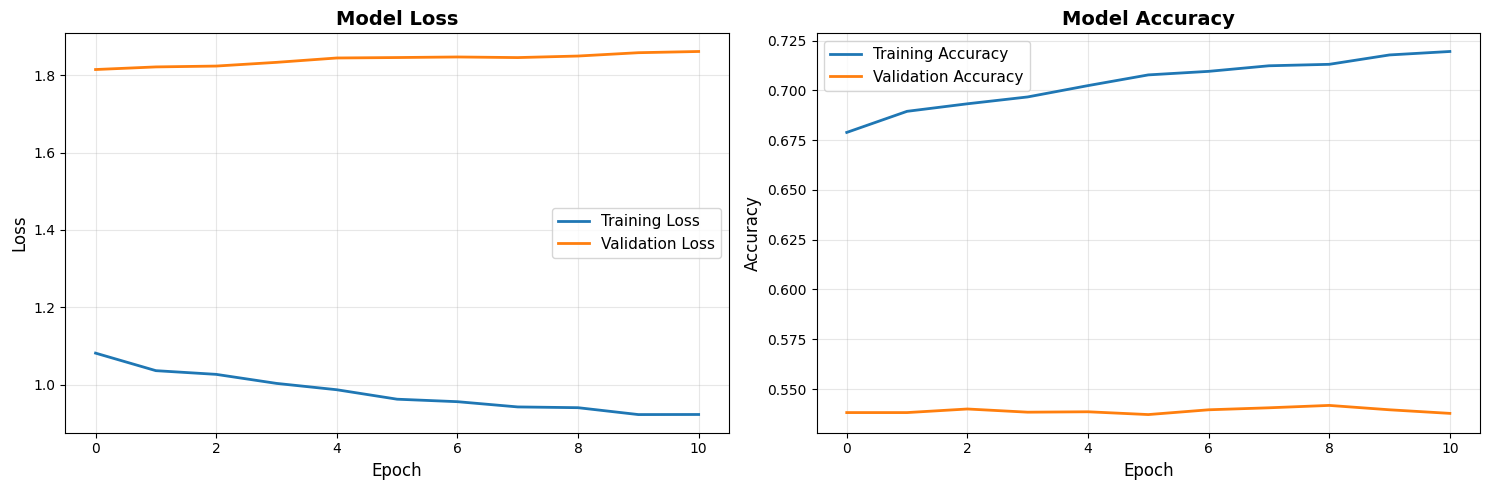

In [11]:
# Vẽ biểu đồ loss và accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot Accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5374 - loss: 1.8071
Test Loss: 1.8071
Test Accuracy: 0.5374 (53.74%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


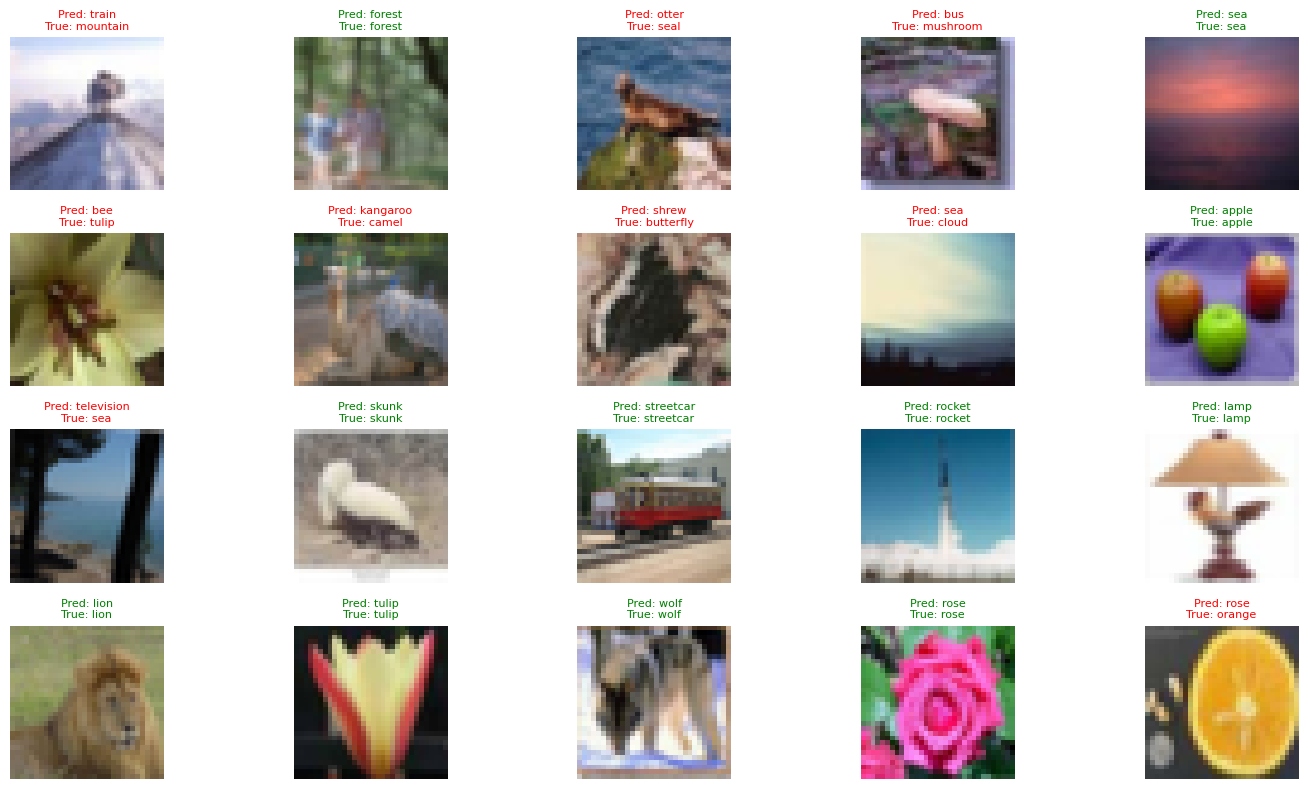

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step

Classification Report (first 10 classes):
               precision    recall  f1-score   support

        apple       0.78      0.80      0.79       100
aquarium_fish       0.68      0.62      0.65       100
         baby       0.35      0.48      0.40       100
         bear       0.31      0.25      0.28       100
       beaver       0.34      0.38      0.36       100
          bed       0.48      0.56      0.52       100
          bee       0.54      0.66      0.59       100
       beetle       0.69      0.56      0.62       100
      bicycle       0.69      0.62      0.65       100
       bottle       0.71      0.69      0.70       100

    micro avg       0.54      0.56      0.55      1000
    macro avg       0.56      0.56      0.56      1000
 weighted avg       0.56      0.56      0.56      1000



In [12]:
# Đánh giá model trên test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Dự đoán và hiển thị một số mẫu
predictions = model.predict(X_test[:20])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test[:20], axis=1)

# Hiển thị kết quả dự đoán
plt.figure(figsize=(15, 8))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test[i])
    
    color = 'green' if predicted_classes[i] == true_classes[i] else 'red'
    plt.title(f"Pred: {class_names[predicted_classes[i]]}\n"
              f"True: {class_names[true_classes[i]]}", 
              fontsize=8, color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# In confusion matrix cho một số lớp
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report (first 10 classes):")
print(classification_report(
    y_true_classes, 
    y_pred_classes, 
    labels=range(10),
    target_names=class_names[:10]
))

In [13]:
# Lưu model
model_save_path = r'C:\Users\LENOVO\Desktop\DeepLearning/bigkernel_cnn_cifar100.h5'
model.save(model_save_path)
print(f"Model đã được lưu tại: {model_save_path}")

# Để load model sau này:
# from tensorflow.keras.models import load_model
# loaded_model = load_model(model_save_path)

Model đã được lưu tại: C:\Users\LENOVO\Desktop\DeepLearning/bigkernel_cnn_cifar100.h5


In [42]:
# === ĐƯỜNG DẪN & THƯ MỤC (WINDOWS-FRIENDLY) ===
from pathlib import Path
import os

base_dir = Path(r"C:\Users\LENOVO\Desktop\DeepLearning")
base_dir.mkdir(parents=True, exist_ok=True)

# file .h5 (best weights theo val_loss)
h5_path = base_dir / "bigkernel_cnn_cifar100.h5"

# SavedModel (thư mục)
savedmodel_dir = base_dir / "bigkernel_cnn_cifar100_savedmodel"

# TensorBoard logs
tb_logdir = base_dir / "logs" / "fit"

print("Sẽ lưu .h5 vào:", h5_path)
print("Sẽ lưu SavedModel vào:", savedmodel_dir)
print("TensorBoard logdir:", tb_logdir)


Sẽ lưu .h5 vào: C:\Users\LENOVO\Desktop\DeepLearning\bigkernel_cnn_cifar100.h5
Sẽ lưu SavedModel vào: C:\Users\LENOVO\Desktop\DeepLearning\bigkernel_cnn_cifar100_savedmodel
TensorBoard logdir: C:\Users\LENOVO\Desktop\DeepLearning\logs\fit


In [45]:
%tensorboard --logdir "C:\Users\LENOVO\Desktop\DeepLearning\logs\fit" --port 6010


Reusing TensorBoard on port 6010 (pid 33828), started 0:01:52 ago. (Use '!kill 33828' to kill it.)

In [8]:
#@title TensorBoard
%load_ext tensorboard
%tensorboard --logdir ./tb_logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10180), started 5:02:47 ago. (Use '!kill 10180' to kill it.)